In [1]:
from tqdm import tqdm
import glob
import os
import json
import pandas as pd
import pylab as plt
from genderize import Genderize

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 300

In [3]:
filepath = "../PYTHON/SELECT-COMMITTEES/"
committees = glob.glob(filepath+"/*")

In [4]:
print("No 2017-19 minutes found for: \n")
for committee in tqdm(committees):
    
    jsnfile = committee+"/Formal-Minutes-17-19.json"
    if not os.path.exists(jsnfile):
        print(committee.split('/')[-1])



100%|██████████| 45/45 [00:00<00:00, 10211.19it/s]

No 2017-19 minutes found for: 

HIGH-SPEED-RAIL-WEST-MIDLANDS-–-CREWE-BILL-SELECT-COMMITTEE
LIAISON-SUB-COMMITTEE-ON-THE-EFFECTIVENESS-AND-INFLUENCE-OF-THE-SELECT-COMMITTEE-SYSTEM
TREASURY-SUB-COMMITTEE
MEMBERS-EXPENSES-COMMITTEE
PROCEDURE-COMMITTEE-COMMONS
PRIVILEGES-COMMITTEE
REGULATORY-REFORM-COMMITTEE
STANDARDS-COMMITTEE
PUBLIC-ACCOUNTS-COMMITTEE
TREASURY-COMMITTEE
STANDING-ORDERS-PRIVATE-BILLS-COMMONS
BACKBENCH-BUSINESS-COMMITTEE
SUB-COMMITTEE-ON-DISINFORMATION
FINANCE-COMMITTEE
SELECTION-COMMONS


In [5]:
genderize = Genderize(
                  user_agent='GenderizeDocs/0.0',
                  api_key='yourownapihere',
                  timeout=30.0)

In [6]:
def filter_gender_data(df):
    
    """
        Function to filter out un-gendered names and
        low probability names
    """
    
    cols = df.filter(['name','count','gender'])
    cols1 = cols[cols['count']>8]
    
    return cols1

In [7]:
def count_gender(df):
    
    """
        Function to count up the number of men and women
        in the list
    """
    
    if len(df['gender'].value_counts().keys())==2:
        key1, key2 = df['gender'].value_counts().keys()
        no1, no2 = df['gender'].value_counts()
    elif len(df['gender'].value_counts().keys())==1:
        key1 = df['gender'].value_counts().keys()[0]
        no1 = df['gender'].value_counts()[0]
        no2 = 0
    else:
        no1 = 0
        no2 = 0
        key1='male'
    
    if key1=='male':
        men = no1
        women = no2
    else:
        men = no2
        women = no1
    
    return men,women

In [8]:
def get_gender_stats(wlist):
    
    # extract first names from the list of names:
    if len(wlist)>1:
        first_names = [name[1] for name in wlist]
    else:
        first_names = wlist[0][1]
        
    # run the genderize service to extract genders for each name:
    results = (genderize.get(first_names))
    
    # create a dataframe of the results:
    df = pd.DataFrame(results)
    
    # clean data:
    df = filter_gender_data(df)
    
    # count genders:
    men, women = count_gender(df)
    
    return men, women

In [9]:
male=[]; female=[]; names=[]
for committee in tqdm(committees):
    
    jsnfile = committee+"/Formal-Minutes-17-19.json"
    if os.path.exists(jsnfile):
        
        # get data for meetings of committee:
        input_file  = open(jsnfile, "r")
        meetings = json.loads(input_file.read())
        
        # initialise counts:
        total_men = 0; total_women = 0; total_all = 0

        # loop through meetings
        for meeting in meetings:
            
            # extract list of witnesses:
            wlist = meeting['witnesses']
            
            # extract gender stats for list:
            if wlist!="None" and len(wlist)>0:
                men, women = get_gender_stats(wlist)
                
            else:
                men = 0
                women = 0
            
            # add to total for this committee:
            total_men+=men
            total_women+=women
            total_all+=men+women
            
        # append total for this committee to the list of committees:
        if total_all>0:
            male.append(total_men/total_all * 100)
            female.append(total_women/total_all * 100)
            names.append(committee.split('/')[-1])

100%|██████████| 45/45 [02:15<00:00,  3.71s/it]


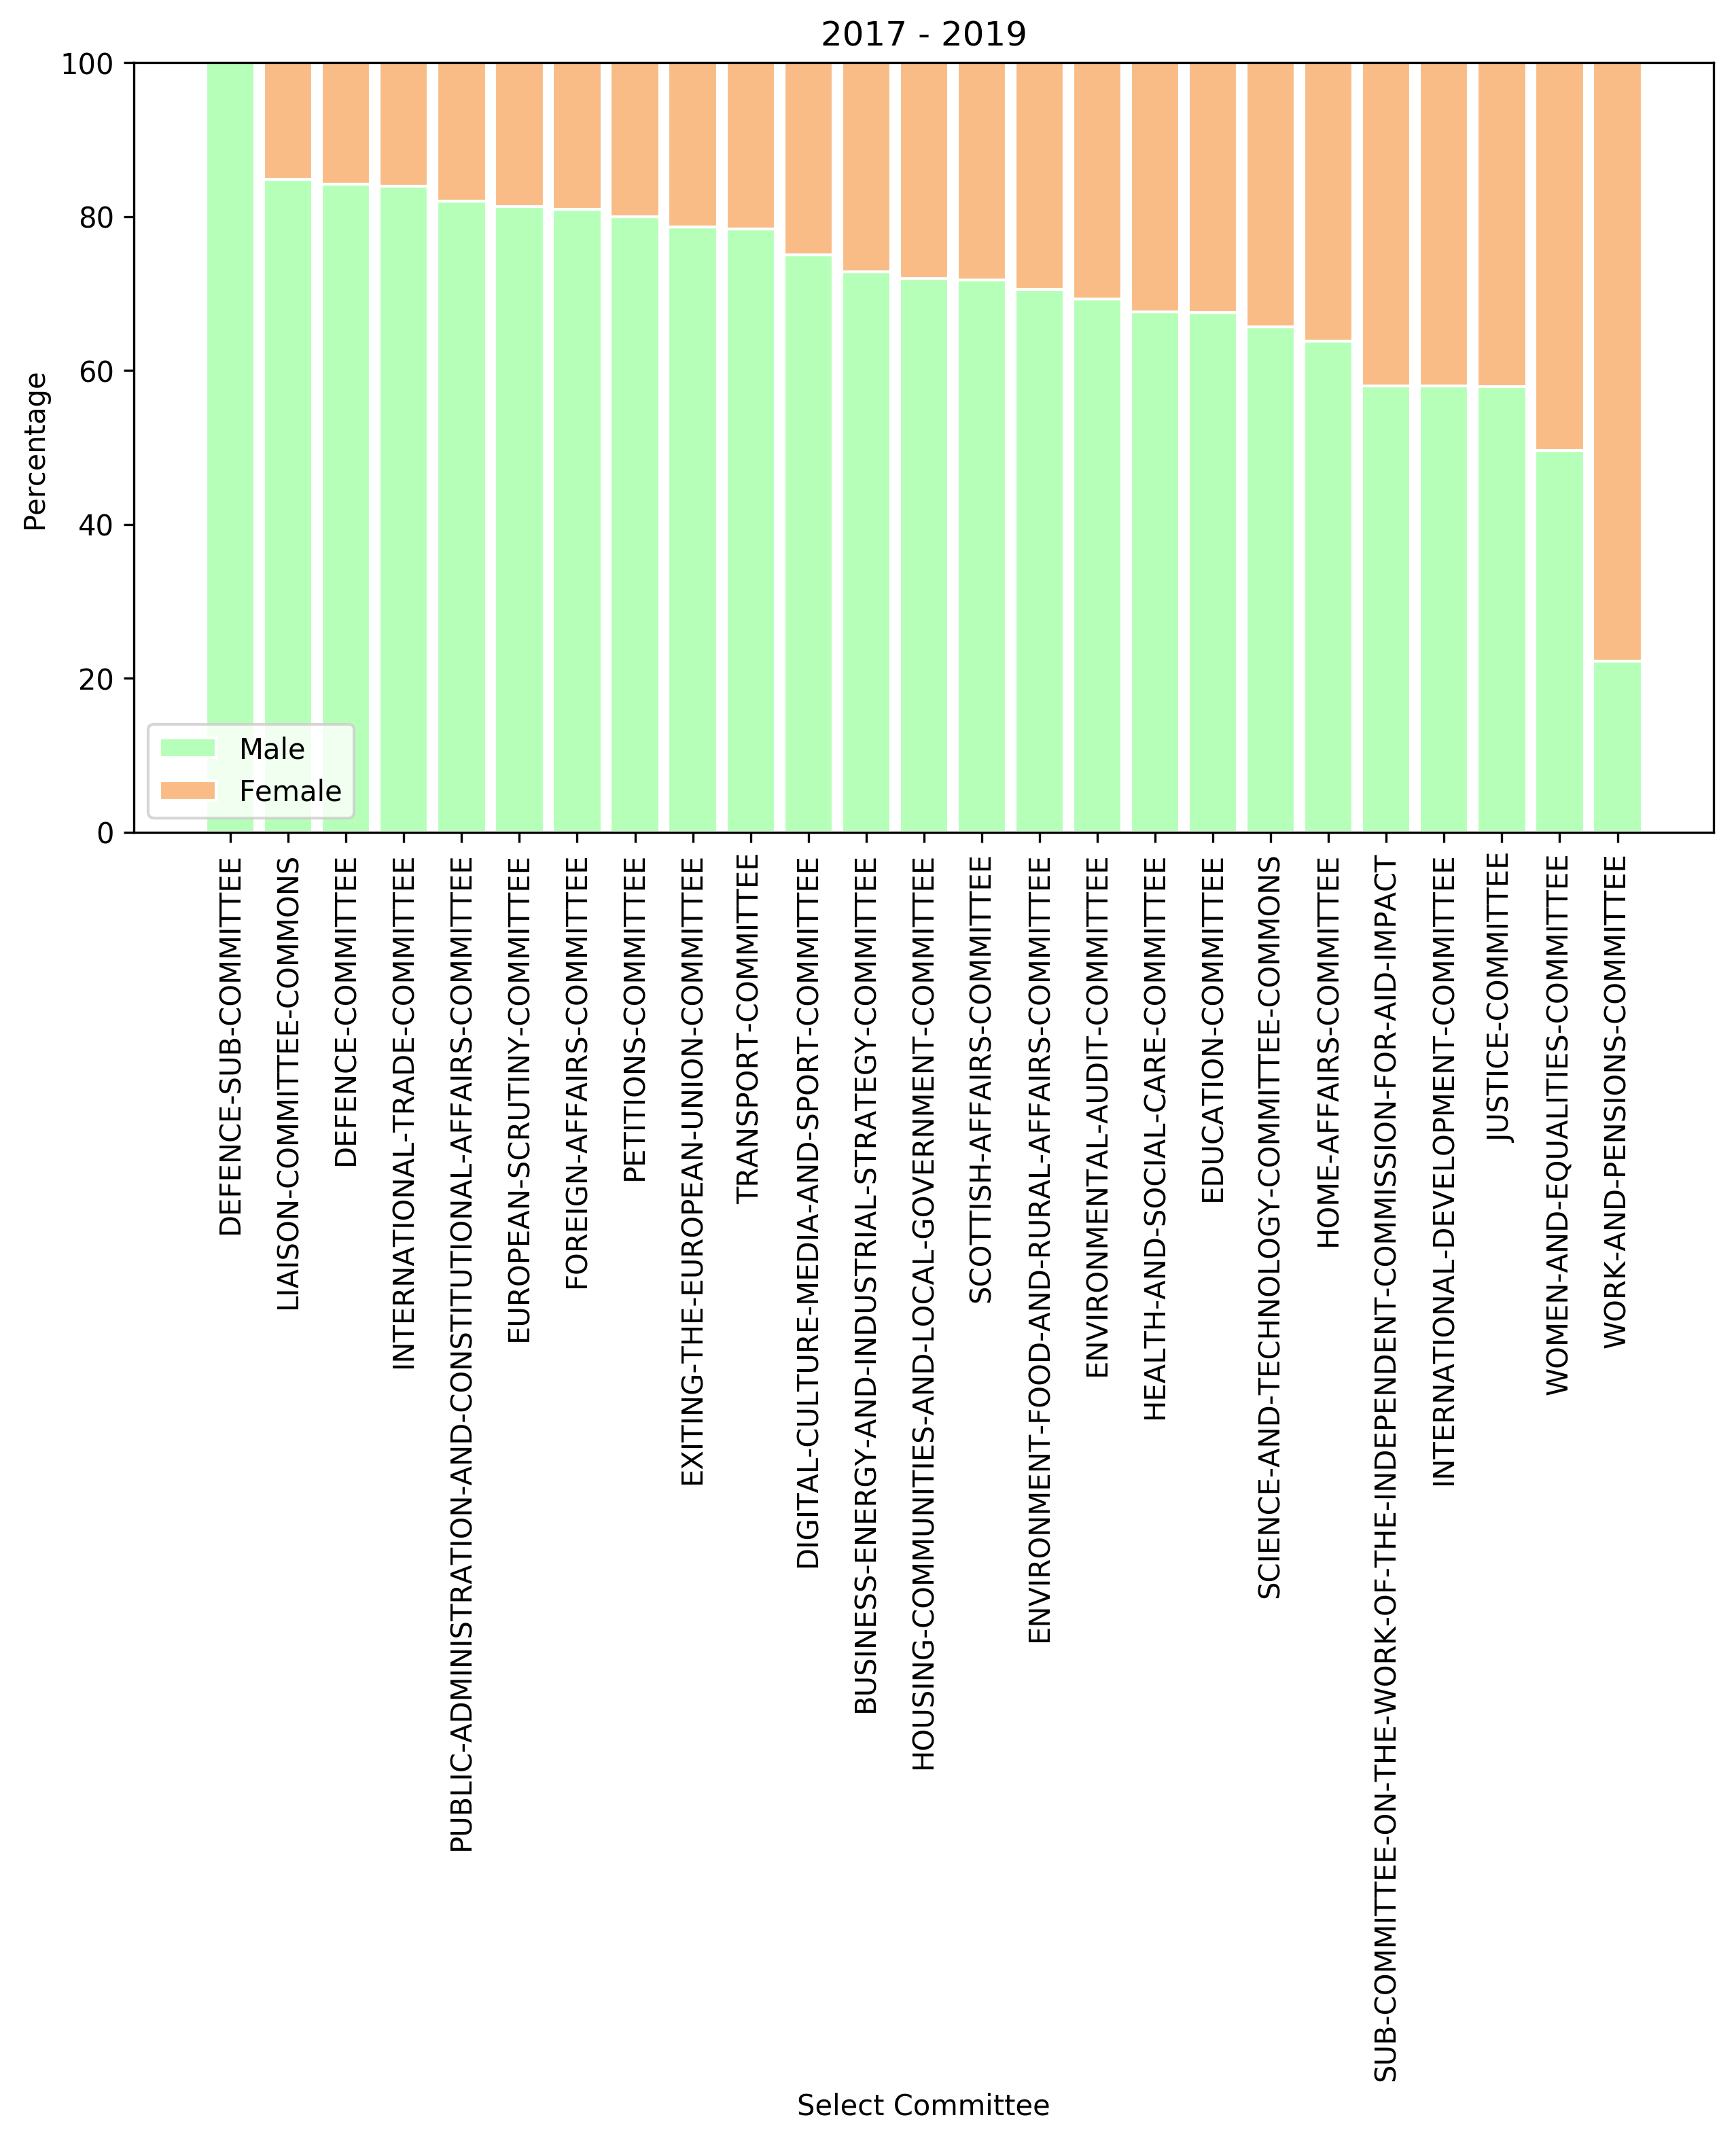

In [10]:
# Data to plot:
raw_data = {'name': names, 'male': male, 'female': female}
df = pd.DataFrame(raw_data)
df = df.sort_values(by=['female'])
r = range(0,len(df['name']))

# plot
barWidth = 0.85
# Create green Bars
plt.bar(r, df['male'], color='#b5ffb9', edgecolor='white', width=barWidth)
# Create orange Bars
plt.bar(r, df['female'], bottom=df['male'], color='#f9bc86', edgecolor='white', width=barWidth)
 
# Custom x axis
plt.xticks(r, df['name'], rotation='vertical')
plt.xlabel("Select Committee")
plt.ylabel("Percentage")

# Add legend
Gender=['Male','Female']
plt.legend(Gender,loc=3)

# Title:
plt.title("2017 - 2019")

# Show graphic
plt.show()